**=====================================================**  
# Grain Storage Analysis

Noah MacGillivray | BIT-446 Assignment(T8) | Summer 2025 

Random Forest 

**Environment:** Ubuntu, VS Code, Python Version: 3.10.12  

**=====================================================**

## Package Imports 

In [15]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# File handling
import os
import openpyxl

# Preprocessing 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Machine learning
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import kds

# Display options
pd.set_option('display.max_columns', None)

print("Environment setup complete!")

Environment setup complete!


## Data Import and Initial Exploration 
The grain storage bin data is read in, head/tail/summary are printed to
ensure proper import and view summary. 

In [16]:
try:
    grain_storage = pd.read_excel('BIT-446-RS-T8-GrainStorageBins1.xlsx', sheet_name='TrainTestData')
    df_info = pd.read_excel('BIT-446-RS-T8-GrainStorageBins1.xlsx', sheet_name='Info')
    print("Sheets loaded successfully")
    
except FileNotFoundError:
    print("Error: File not found.")
    
except ValueError as e:
    print(f"Error: Sheet name issue - {e}")
    
except Exception as e:
    print(f"Unexpected error: {e}")

# Print head
print("\n---- Data sheet TrainTestData head ----")
print("\n",grain_storage.head())

# Print tail
print("\n---- Data sheet TrainTestData tail ----")
print("\n", grain_storage.tail(), "\n")

# Display df info
print("-- Data sheet TrainTestData information --\n")
grain_storage.info()

# Check for missing values 
df_check_na = grain_storage.isnull().any().any()
print("\nTrainTestData missing iformation: ", df_check_na)


print("\n--- Data sheet TrainTestData feature variable information ---")
with pd.option_context('display.max_colwidth', None):
    display(df_info)



Sheets loaded successfully

---- Data sheet TrainTestData head ----

    record  product dryer   warranty  stdbushels  purchased
0       1    Elite    No   Extended       36204          1
1       2    Elite    No  InService       22001          0
2       3  Premium    No   Extended       10583          0
3       4  Premium    No   Extended       40217          0
4       5  Premium    No   Extended       15910          0

---- Data sheet TrainTestData tail ----

       record  product dryer   warranty  stdbushels  purchased
1195    1196  Premium    No   Extended       46788          0
1196    1197    Elite    No  InService       12952          0
1197    1198    Basic   Yes   Standard       39862          0
1198    1199    Basic   Yes   Standard       32463          0
1199    1200  Premium    No   Extended       27140          0 

-- Data sheet TrainTestData information --

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 6 columns):
 #   Colu

,Unnamed: 0,Unnamed: 1
0,Variable,Definition
1,record,"record number (i.e., index field)"
2,product,grain storage bin product type
3,dryer,0 = dryer not provided for a given grain storage bin; 1 = dryer provided for a given grain storage bin
4,warranty,type of warranty offered for a given grain storage bin
5,stdbushels,"volume of the grain storage bin, in standard bushels"
6,purchased,0 =grain storage bin was not purchased; 1 = grain storage bin was purchased; this is the target variable for the model


## Feature selection and preprocessing 

In [17]:
# Create copy of df
grain_storage_numeric = grain_storage.copy()

# Change object categories to numeric
le = LabelEncoder()
for col in ['product', 'dryer', 'warranty']:
    grain_storage_numeric[col] = le.fit_transform(grain_storage_numeric[col])

# Build feature column list 
feature_columns = [col for col in grain_storage_numeric.columns if col != 'purchased']

# Define features 
X = grain_storage_numeric[feature_columns]
# Confirm correct features 
print("---- Features after conversion confirmation ----\n")
print(X)
print()

# Define target variable 
y = grain_storage_numeric['purchased']
# Confirm target variable 
print("---- Target variable confirmation ----\n")
print(y)

# Performs a random split with seed; 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=3)
print("\nData split confirmation\n")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


---- Features after conversion confirmation ----

      record  product  dryer  warranty  stdbushels
0          1        1      0         0       36204
1          2        1      0         1       22001
2          3        3      0         0       10583
3          4        3      0         0       40217
4          5        3      0         0       15910
...      ...      ...    ...       ...         ...
1195    1196        3      0         0       46788
1196    1197        1      0         1       12952
1197    1198        0      1         2       39862
1198    1199        0      1         2       32463
1199    1200        3      0         0       27140

[1200 rows x 5 columns]

---- Target variable confirmation ----

0       1
1       0
2       0
3       0
4       0
       ..
1195    0
1196    0
1197    0
1198    0
1199    0
Name: purchased, Length: 1200, dtype: int64

Data split confirmation

X_train shape: (960, 5)
X_test shape: (240, 5)
y_train shape: (960,)
y_test shape: (240,)


## Create and Fit Random Forest Classifier 

In [18]:
rfclf = RandomForestClassifier(
    bootstrap=True,
    class_weight=None,
    criterion='entropy',
    max_depth=8,
    max_leaf_nodes=3,
    max_samples=200,
    min_impurity_decrease=0.0,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    n_estimators=500,
    n_jobs=1,
    oob_score=False,
    random_state=38,
    verbose=0,
    warm_start=False
)

rfclf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, max_leaf_nodes=3,
                       max_samples=200, n_estimators=500, n_jobs=1,
                       random_state=38)

## Obtain Important Features 

In [19]:
feature_scores = pd.Series(rfclf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("------ Most Important Features -------\n")
print(feature_scores)

------ Most Important Features -------

warranty      0.420809
product       0.365652
stdbushels    0.082599
dryer         0.077025
record        0.053916
dtype: float64


## Predict Responses for the Test Data

In [20]:
# Make predictions on test data
y_pred = rfclf.predict(X_test)

## Classification Report, Confusion Matrix, and KDS Visualizations

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       169
           1       1.00      0.49      0.66        71

    accuracy                           0.85       240
   macro avg       0.91      0.75      0.78       240
weighted avg       0.88      0.85      0.83       240

--------- Confusion matrix ---------

          Predicted 0  Predicted 1
Actual 0          169            0
Actual 1           36           35 



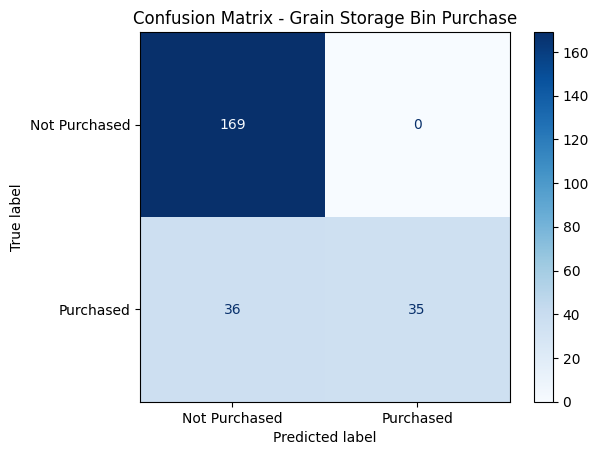


Generating KDS performance plots...
LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of event

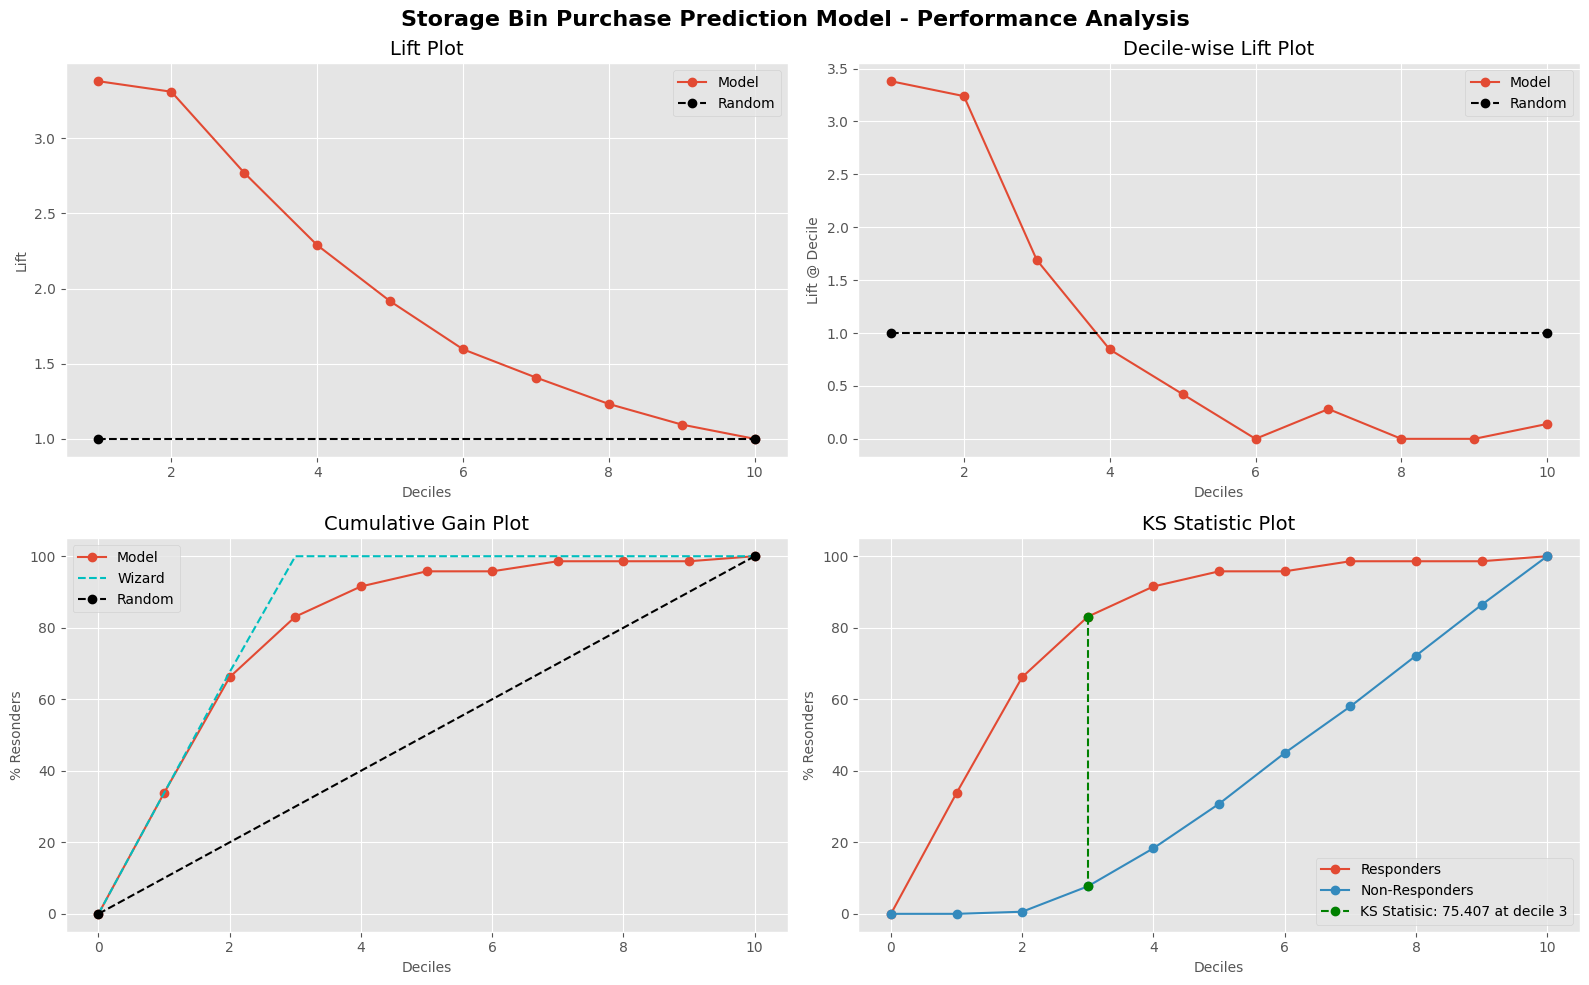

In [21]:
# Generate and print the classification report
print("--------------- Classification Report ---------------\n")
class_report = classification_report(y_test, y_pred)
print(class_report)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred) 
print("--------- Confusion matrix ---------\n")
cm_df = pd.DataFrame(cm, 
                     index=['Actual 0', 'Actual 1'], 
                     columns=['Predicted 0', 'Predicted 1'])
print(cm_df,"\n")

# Create a confusion matrix visualization 
labels = ["Not Purchased", "Purchased"]
# Use ConfusionMatrixDisplay for visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Grain Storage Bin Purchase')
plt.show()

#
print("\nGenerating KDS performance plots...")

# 
y_pred_proba = rfclf.predict_proba(X_test)[:, 1] 

# Set global plot style to use ggplot 
plt.style.use('ggplot')

# Generate all 4 plots at once using kds.metrics.report
fig = kds.metrics.report(
    y_true=y_test,
    y_prob=y_pred_proba,
)
plt.suptitle('Storage Bin Purchase Prediction Model - Performance Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## Comprehensive Metrics 